# Q Learning & Sarsa : Crossing Volcano 

In this Notebook, we'll implement an agent <b>that plays the Volcano crossing problem.</b>

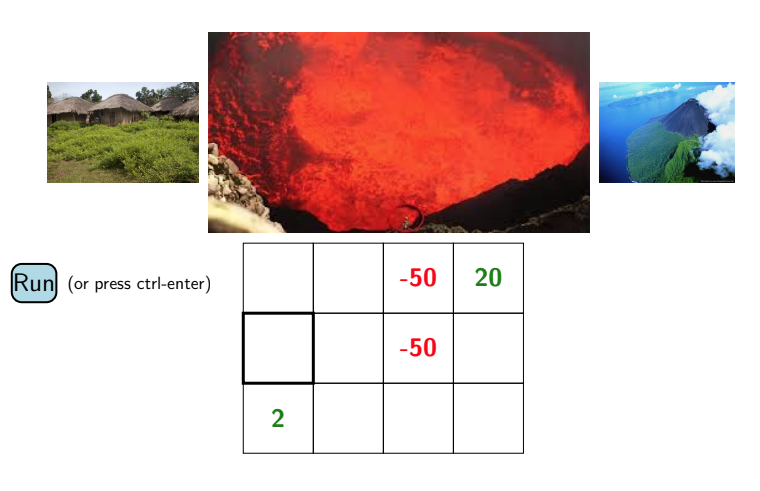
<!-- 
The goal of this game is <b>to go from the starting state (S) to the goal state (G)</b> by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery, **so you won't always move in the direction you intend (stochastic environment)**

Thanks to [lukewys](https://github.com/lukewys) for his help -->


## Step 0: Import the dependencies 📚


In [1]:
import numpy as np
import random
from typing import Optional
from gym import Env, spaces, utils

In [2]:
# setting the Directions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

action2str = [" ⬅️ ", " ⬇️ ", " ➡️ ", " ⬆️ "]

# Creating a Map 
MAPS = {
    "4x3": ["OOVG", "SOVO", "gOOO"],
        
    "8x6": ["OOGOOOOO", 
            "OOVVVOOO", 
            "OOVVVOOO", 
            "OOOOOOOO", 
            "OOOOSOgO", 
            "OOOOOOOO"],    
}

In [3]:
# Creating the class
class Volcano(Env):
    def __init__(
        self,
        render_mode: Optional[str] = None,
        desc=None,
        # map_name="4x3",
        map_name="8x6",
        slip_prob=0.1,
    ):
        desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}
        for row in range(nrow):
            for col in range(ncol):
                s = self.to_s(row, col)
                for a in range(4):
                    letter = desc[row, col]
                    if letter in b"VgG":
                        self.P[s][a].append((1.0, s, 0, True))
                    else:
                        li = self.update_transition(slip_prob, self.P[s][a], row, col, a)
        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

    def update_transition(self, slip_prob, li, row, col, a):
        """
        Problem 1: 
        Define the transition probability matrix self.P. 

        The MDP follows a slip probability (slip_prob). If slippery, the agent will randomly move in all the 4 directions;

        Input:
         slip_prob: the slippery probability 
         trans_p: the transition probability matrix to update 
         row, col: the current row and column 
         a: the action, reward, terminated) to the list li. This tuple represents the probability of moving in this direction 
         (since there is only one possible direction), the new state, the reward for moving to the new state, and the 
         termination status of the new state
        """
        #########################################PROBLEM 1 STARTS HERE########################################
        # get current state
        s = self.to_s(row, col)

        transitions = []
        rewards = {'G': 20, 'g': 10, 'V': -50, 'default': -0.1}

        for b in [(a - 1) % 4, a, (a + 1) % 4]:
            newrow, newcol = self.inc(row, col, b)
            newstate = self.to_s(newrow, newcol)
            letter = self.desc[newrow, newcol]
            if letter == b"V":
                transitions.append((slip_prob / 2, s, rewards['V'], True))
            elif letter == b"G":
                transitions.append((slip_prob / 2, newstate, rewards['G'], True))
            elif letter == b"g":
                transitions.append((slip_prob / 2, newstate, rewards['g'], True))
            else:
                transitions.append((slip_prob / 2, newstate, rewards['default'], False))

        # normalize transition probabilities
        prob_sum = sum([t[0] for t in transitions])
        transitions = [(t[0]/prob_sum, t[1], t[2], t[3]) for t in transitions]

        # update transition probabilities
        li.extend(transitions)
        return li
        ##############################################END HERE################################################
    
    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == LEFT:
            col = max(col - 1, 0)
        elif a == DOWN:
            row = min(row + 1, self.nrow - 1)
        elif a == RIGHT:
            col = min(col + 1, self.ncol - 1)
        elif a == UP:
            row = max(row - 1, 0)
        return (row, col)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(range(len(transitions)), p=[t[0] for t in transitions])
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        return (int(s), r, t, False, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        
        self.s = np.random.choice(len(self.initial_state_distrib), p=self.initial_state_distrib)
        self.lastaction = None

        return int(self.s), {"prob": 1}

    def render(self):
        desc = self.desc.tolist()
        out_str = ""

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            out_str += f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n"
        else:
            out_str += "\n"
        out_str += "\n".join("".join(line) for line in desc) + "\n"

## Step 1: Create the environment 🎮
- Here we'll create the Crossing Volcano environment. 
- OpenAI Gym is a library <b> composed of many environments that we can use to train our agents. Also we can define our own environment.</b>
- In our case we choose to define Crossing Volcano.

In [4]:
env = Volcano()
print(type(env))

<class '__main__.Volcano'>


## Step 2: Create the Q-table and initialize it 🗄️
- Now, we'll create our Q-table, to know how much rows (states) and columns (actions) we need, we need to calculate the action_size and the state_size
- OpenAI Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`

In [5]:
action_size = env.action_space.n
state_size = env.observation_space.n

## Step 3: Create the hyperparameters ⚙️
- Here, we'll specify the hyperparameters

In [6]:
TOTAL_EPISODES = 20000       # Total episodes
MAX_STEPS = 99               # Max steps per episode

## Step 4: The Q learning algorithm 🧠
- Now we implement the Q learning algorithm:
  <!-- ![alt text](http://simoninithomas.com/drlc/Qlearning//qtable_algo.png) -->
  ![alt text](https://tcnguyen.github.io/reinforcement_learning/images/Q_learning_algo.png)
  

In [7]:
def Q_learning(hyperparameters):
    # Create our Q table with state_size rows and action_size columns 
    qtable = np.zeros((state_size, action_size))    
    learning_rate = hyperparameters["learning_rate"]
    gamma = hyperparameters["gamma"]
    epsilon = hyperparameters["epsilon"]
    rewards = []
    for episode in range(TOTAL_EPISODES):
        state, _ = env.reset()
        step = 0
        done = False
        total_rewards = 0
        for step in range(MAX_STEPS):
            if random.uniform(0, 1) > epsilon:
                action = np.argmax(qtable[state,:])
            else:
                action = env.action_space.sample()
            new_state, reward, done, _, info = env.step(action)
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
            total_rewards += reward
            state = new_state
            if done == True: 
                break
        rewards.append(total_rewards)
    print ("Score over time: " +  str(sum(rewards)/TOTAL_EPISODES))
    return qtable

## Step 5: The Sarsa algorithm 🧠
- Now we implement the Sarsa algorithm:

![alt text](https://tcnguyen.github.io/reinforcement_learning/images/SARSA_algo.png)

In [8]:
def choose_action(state, epsilon, qtable):
    action=0
    epsilon = 1.
    if np.random.uniform(0, 1) > epsilon:
        action = np.argmax(qtable[state, :])
    else:
        action = env.action_space.sample()
    return action

In [9]:
def SARSA(hyperparameters):
    """
    Problem 2

    Implement the SARSA algorithm.

    Input: hyperparameters including the learning rate the discounting factor

    Output: the qtable learned by SARSA

    """
    qtable = np.zeros((state_size, action_size))
    #########################################PROBLEM 2 STARTS HERE#########################################
    # get values
    learningRate = hyperparameters["learning_rate"]
    gamma = hyperparameters["gamma"]
    epsilon = hyperparameters["epsilon"]

    # initialize rewarads
    rewards = []

    # loop through each episode
    for episode in range(TOTAL_EPISODES):
        # initialize S
        state, _ = env.reset()
        step = 0
        done = False
        total_rewards = 0

        # choose A from S using choose_action
        action = choose_action(state, epsilon, qtable)

        # loop through each step in episode
        for step in range(MAX_STEPS):
            # take action A, observe R, S'
            newState, reward, done, _, info = env.step(action)

            # choose A' from S' using choose_action
            newAction = choose_action(newState, epsilon, qtable)

            # Q(S,A) <-- Q(S,A) + alpha * [R + gamma * Q(S',A') - Q(S,A)]
            qtable[state, action] = qtable[state, action] + learningRate * (reward + gamma * qtable[newState, newAction] - qtable[state, action])

            # S <-- S'; A <-- A'
            state = newState
            action = newAction

            if done == True:
                break
        
        rewards.append(total_rewards)
    ####################################END HERE################################################

    print("(SARSA) Score over time: " +  str(sum(rewards)/TOTAL_EPISODES))
    return qtable

In [10]:
def policy_evaluation(qtable):
    env.reset()
    rewards = []
    raveled_states = env.desc.ravel()

    for episode in range(100):
        state, _ = env.reset()
        step = 0
        done = False
        print("****************************************************")
        print("EPISODE ", episode)

        
        for step in range(MAX_STEPS):
            action = np.argmax(qtable[state,:])
            
            new_state, reward, done, _, info = env.step(action)

            if done:
                img = env.render()
            
                if raveled_states[new_state] == b"g":
                    print("We reached the village 🏠")
                elif raveled_states[new_state] == b"G":
                    print("We reached the fabulous view 🌊")
                else:
                    print("We fell into the volcano 🌋")
                print("Number of steps", step)
                rewards.append(reward)
                
                break
            state = new_state
    print("Average reward of policy:", np.mean(rewards))

In [11]:
qtable = SARSA(hyperparameters = {"learning_rate": 0.3, "gamma": 0.95, "epsilon": 1.0})
policy = "\n" + "\n".join(["".join([action2str[x] for x in each_list]) for each_list in np.argmax(qtable, axis=1).reshape((6, 8))])
print("Policy: ", policy)
policy_evaluation(qtable)

(SARSA) Score over time: 0.0
Policy:  
 ⬆️  ⬆️  ⬅️  ⬆️  ⬆️  ⬇️  ➡️  ➡️ 
 ⬅️  ⬅️  ⬅️  ⬅️  ⬅️  ➡️  ➡️  ➡️ 
 ➡️  ⬅️  ⬅️  ⬅️  ⬅️  ➡️  ➡️  ➡️ 
 ⬅️  ⬅️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️  ⬇️ 
 ➡️  ⬇️  ⬇️  ⬇️  ⬆️  ⬇️  ⬅️  ⬇️ 
 ⬅️  ⬇️  ⬅️  ➡️  ➡️  ⬆️  ➡️  ⬅️ 
****************************************************
EPISODE  0
We reached the village 🏠
Number of steps 10
****************************************************
EPISODE  1
We reached the village 🏠
Number of steps 41
****************************************************
EPISODE  2
We reached the village 🏠
Number of steps 11
****************************************************
EPISODE  3
We reached the village 🏠
Number of steps 16
****************************************************
EPISODE  4
We reached the village 🏠
Number of steps 19
****************************************************
EPISODE  5
We reached the village 🏠
Number of steps 3
****************************************************
EPISODE  6
We reached the village 🏠
Number of steps 68
********

In [12]:
qtable = Q_learning(hyperparameters = {"learning_rate": 0.3, "gamma": 0.95, "epsilon": 1.0})
policy = "\n" + "\n".join(["".join([action2str[x] for x in each_list]) for each_list in np.argmax(qtable, axis=1).reshape((6, 8))])
print("Policy: ", policy)
policy_evaluation(qtable)

Score over time: -26.87624499999878
Policy:  
 ⬆️  ⬆️  ⬅️  ⬆️  ⬆️  ⬇️  ⬆️  ⬇️ 
 ⬆️  ➡️  ⬅️  ⬅️  ⬅️  ➡️  ➡️  ➡️ 
 ⬆️  ⬅️  ⬅️  ⬅️  ⬅️  ➡️  ⬅️  ⬇️ 
 ⬆️  ⬅️  ⬇️  ⬇️  ⬇️  ➡️  ➡️  ⬅️ 
 ⬆️  ⬅️  ⬅️  ⬆️  ⬇️  ⬇️  ⬅️  ⬇️ 
 ⬅️  ⬅️  ⬆️  ➡️  ➡️  ➡️  ➡️  ⬅️ 
****************************************************
EPISODE  0
We reached the village 🏠
Number of steps 25
****************************************************
EPISODE  1
We reached the village 🏠
Number of steps 1
****************************************************
EPISODE  2
We reached the fabulous view 🌊
Number of steps 36
****************************************************
EPISODE  3
We reached the village 🏠
Number of steps 1
****************************************************
EPISODE  4
We reached the fabulous view 🌊
Number of steps 13
****************************************************
EPISODE  5
We reached the fabulous view 🌊
Number of steps 57
****************************************************
EPISODE  6
We reached the village 🏠
Num